  ## **Assignment 3: Parameter Estimation**

---

The goal of this exercise is to explore different ways, parametric and non-parametric, of estimating the probability density function of a distribution.

The parametric algorithm that will be implemented first, is the 'Maximum Likelihood Estimation', whereas the non-parametric that will be shown are, the 'Parzen Windows' and 'K-Nearest Neighbors' algorithms.




# **PART A: Maximum Likelihood Estimation**

Given 100 samples for each of 3 distributions, we are tasked with estimating the mean and covariance of all of them. <br>

Asumming that the distributions folllow a guassian one, we can estimate them using MLE. <br>

Using this assumption we can define a closed formula for both the mean vector as well as the covariance matrix, making our estimation both easy and fast to calculate.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches


class Distribution:
    # Input 1: Name of distribution
    # Input 2: nX2x1 array of samples
    # Constructor
    def __init__(self, _name, _samples):
        self.name = _name
        self.samples = self.format_samples(_samples)
        self.mean = None
        self.cov = None
        self.probs = None

    def run(self):
        self.mean = self.calc_mean()
        self.cov = self.calc_cov()
        self.probs = self.calc_probs()

    # Format the input samples to be a nX2x1 array
    def format_samples(self, _samples):
        np_samples = np.asarray(_samples)
        return np_samples.reshape(-1, 2, 1)

    def calc_mean(self):
        return (1 / len(self.samples)) * np.sum(self.samples, axis=0)

    def calc_cov(self):
        # calculate the difference between each sample and the mean
        diffs = self.samples - self.mean

        sum = 0
        for dif in diffs:
            sum += np.matmul(dif, np.transpose(dif))

        return (1 / len(self.samples)) * sum

    def calc_probs(self, samples=None):

        # if samples is not given, use the samples of the distribution
        if samples is None:
            samples = self.samples

        # calculate the exponent
        exp = np.matmul(np.matmul(np.transpose(samples - self.mean, (0, 2, 1)), np.linalg.inv(self.cov)),
                        (samples - self.mean))

        # calculate the denominator
        denom = np.sqrt(np.linalg.det((2 * np.pi) ** 2 * self.cov))

        # calculate the probability
        prob = np.exp(-0.5 * exp) / denom

        # flatten the array
        return prob.flatten()

    def plot(self):
        # plot the samples
        plt.scatter(self.samples[:, 0], self.samples[:, 1])

        # set the title
        plt.title(self.name)

        # find the min and max of the samples
        min_x = np.min(self.samples[:, 0])
        max_x = np.max(self.samples[:, 0])
        min_y = np.min(self.samples[:, 1])
        max_y = np.max(self.samples[:, 1])

        # create linspace with some padding
        padding = 0.5
        x = np.linspace(min_x - padding, max_x + padding, 100)
        y = np.linspace(min_y - padding, max_y + padding, 100)

        # create meshgrid
        X, Y = np.meshgrid(x, y)
        Xgrid = np.vstack((X.flatten(), Y.flatten())).T

        # calculate the probability using calc_probs
        Z = self.calc_probs(Xgrid.reshape(-1, 2, 1)).reshape(X.shape)

        plt.contour(X, Y, Z)
        plt.show()


def plot_3d(D0, D1, D2, style='3D'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # calculate meshgrid that encompasses all distributions

    # find the min and max of the samples
    min_x = np.min(np.concatenate((D0.samples[:, 0], D1.samples[:, 0], D2.samples[:, 0])))
    max_x = np.max(np.concatenate((D0.samples[:, 0], D1.samples[:, 0], D2.samples[:, 0])))
    min_y = np.min(np.concatenate((D0.samples[:, 1], D1.samples[:, 1], D2.samples[:, 1])))
    max_y = np.max(np.concatenate((D0.samples[:, 1], D1.samples[:, 1], D2.samples[:, 1])))

    # create linspace with some padding
    padding = 0.5
    x = np.linspace(min_x - padding, max_x + padding, 100)
    y = np.linspace(min_y - padding, max_y + padding, 100)
    X, Y = np.meshgrid(x, y)
    Xgrid = np.vstack((X.flatten(), Y.flatten())).T

    # calculate the probability using calc_probs
    Z0 = D0.calc_probs(Xgrid.reshape(-1, 2, 1)).reshape(X.shape)
    Z1 = D1.calc_probs(Xgrid.reshape(-1, 2, 1)).reshape(X.shape)
    Z2 = D2.calc_probs(Xgrid.reshape(-1, 2, 1)).reshape(X.shape)

    if style != '3D':
        max_Z = np.maximum.reduce([Z0, Z1, Z2])
        plt.contourf(X, Y, max_Z, levels=360, cmap='RdYlBu')
    else:
        # calculate the label with the maximum probability for each point in the meshgrid
        max_indices = np.argmax(np.stack((Z0, Z1, Z2), axis=2), axis=2)

        # define the RGB values for each label
        colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

        # create a new array where each point is assigned a color based on the label with the maximum probability
        Z_color = colors[max_indices]

        # set the Z value of each point in the meshgrid to the maximum probability among the three distributions
        Z = np.maximum.reduce([Z0, Z1, Z2])

        # plot the surface with the assigned colors
        ax.plot_surface(X, Y, Z, facecolors=Z_color, linewidth=0.7, antialiased=True, alpha=0.55)

    # add a title
    plt.title("3D plot of all distributions")

    # add labels
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Probability')

    # add label legend based on color (red, green/yellow, blue)
    l0_patch = mpatches.Patch(color='red', label=D0.name)

    if style != '3D':
        l1_patch = mpatches.Patch(color='yellow', label=D1.name)
    else:
        l1_patch = mpatches.Patch(color='green', label=D1.name)

    l2_patch = mpatches.Patch(color='blue', label=D2.name)
    plt.legend(handles=[l0_patch, l1_patch, l2_patch])

    plt.show()


def main():
    # read csv
    samples_data = pd.read_csv("dataA_MLE.csv", header=None)

    # format dataframe, by splitting it into unique labels
    dfs = [group[1].drop(2, axis=1) for group in samples_data.groupby(2)]

    dis0 = Distribution("dis0", dfs[0])
    dis0.run()
    #dis0.plot()

    dis1 = Distribution("dis1", dfs[1])
    dis1.run()
    #dis1.plot()

    dis2 = Distribution("dis2", dfs[2])
    dis2.run()
    #dis2.plot()

    plot_3d(dis0, dis1, dis2, style="3D")
    plot_3d(dis0, dis1, dis2, style="contour")



if __name__ == "__main__":
    main()


# **PART B: Parzen Windows**

We are now asked to estimate the probability density function of a distribution using the Parzen Windows method.

While this algorithm is slower than the MLE that we dove in the previous example, it offers one large benefit. Both 'Parzen Windows' and 'K-nearest Neighbors' are non-parametric algorithms, that dont force us to assume that the distribution is of one kind only.<br>

These algorithms, given a large count of quality samples, can actually approximate the real PDF with a very small deviation.

In more detail, the Parzen Windows method uses a fixed window function to estimate the density at each point, which can be adjusted to achieve different levels of accuracy.<br>

We will be using 2 window shapes, a hypercube and a guassian kernel






In [ ]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.stats import norm
import matplotlib.patches as mpatches




# class is used to bundle all variables required for the animation into 1 struct
class obj_bundler:
    def __init__(self, ax, axis, est_func, real_func, h_n_vals, mse_vals, best_h_n):
        self.ax = ax
        self.axis = axis
        self.est_func = est_func
        self.real_func = real_func
        self.h_n_vals = h_n_vals
        self.mse_vals = mse_vals
        self.best_h_n = best_h_n


def prepare_animation(objects):
    # render each frame
    def animate(frame_number):

        # if previous frame was best estimation, freeze for 2 seconds to show it
        if (frame_number > 0 and objects.h_n_vals[frame_number - 1] == objects.best_h_n):
            time.sleep(2)

        objects.ax.clear()

        objects.ax.set_title('Animation of Estimation')

        # set axis limits
        objects.ax.set_ylim([0, .2])

        # plot animation of curr_est
        plot = objects.ax.bar(objects.axis, objects.est_func[frame_number])

        # plot real distribution
        objects.ax.plot(objects.axis, objects.real_func, color='red', linewidth=2)

        # plot legend
        colors = ['blue', 'red']
        labels = ['Estimated', 'Real']
        patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
        objects.ax.legend(handles=patches)

        objects.ax.text(0.05, 0.95, f'h_n = {objects.h_n_vals[frame_number]:.1f}', transform=objects.ax.transAxes,
                        fontsize=10,
                        verticalalignment='top')

        objects.ax.text(0.05, 0.9, f'mse = {objects.mse_vals[frame_number]:.4f}', transform=objects.ax.transAxes,
                        fontsize=10,
                        verticalalignment='top')

        # if we are at the best h_n, print it and freeze anim for 1 second
        if (objects.best_h_n == objects.h_n_vals[frame_number]):
            objects.ax.text(0.05, 0.8, f'best h_n', transform=objects.ax.transAxes, fontsize=10,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        return plot

    return animate


# hypercube window function
def hypercube_window(x, x_i, h_n):
    return 1 if np.abs(x - x_i) <= h_n / 2 else 0


# gaussian window function
def gaussian_window(x, x_i, h_n):
    return (1 / np.sqrt(2 * np.pi * h_n)) * np.exp(-0.5 * ((x - x_i) / h_n) ** 2)


# Calculate the pdf at a single point x_i
# Input:
#   x_i: the point to calculate the pdf at
#   samples: the samples
#   h_n: the window size
#   kernel: 'hypercube' or 'gaussian'

def parzen_pdf(x_i, samples, h_n, kernel):
    ins_cnt = 0
    for x in samples:
        ins_cnt += kernel(x, x_i, h_n)

    return np.asarray(ins_cnt / (len(samples) * h_n))


# Estimate best window size
# Input:
#   samples: the samples
#   real_dis: the real distribution of the samples
#   kernel: 'hypercube' or 'gaussian'
def parzen_window_selection(samples, real_dis, kernel):
    print(f"In window selection, kernel: {kernel.__name__}")
    
    # define a linspace of x values based on samples
    buffer = 2

    x = np.linspace(np.min(samples) - buffer, np.max(samples) + buffer, 100)

    # define a list of window sizes
    h_n_cands = np.arange(0.2, 10.1, 0.1)

    # define a list to store the pdf values
    pdf_list = []

    # calculate the pdf for each window size
    for h_n in h_n_cands:
        pdf_list.append(np.asarray([parzen_pdf(x_i, samples, h_n, kernel) for x_i in x]))

    # calculate the mean squared error for each window size
    mse_list = []
    for pdf in pdf_list:
        mse_list.append(np.mean((pdf - real_dis) ** 2))
        print(f"mse: {mse_list[-1]}  h_n: {h_n_cands[len(mse_list) - 1]}")

    # find the best window size
    best_h_n = h_n_cands[np.argmin(mse_list)]
    best_dis = pdf_list[np.argmin(mse_list)]

    print(f"Best window size: {best_h_n}")

    # create a 1x3 subplot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # plot the histogram of the samples
    ax[0].hist(samples, bins=100)
    ax[0].set_title('Histogram of Samples')

    # plot real vs best estimated pdf on the same graph

    ax[1].plot(x, real_dis, label='True Distribution', color='red')
    ax[1].plot(x, best_dis, label='Estimated Distribution', color='blue')
    ax[1].set_title('Real vs Estimated Distribution')

    # add a color legend
    red_patch = mpatches.Patch(color='red', label='True Distribution')
    blue_patch = mpatches.Patch(color='blue', label='Estimated Distribution')
    ax[1].legend(handles=[red_patch, blue_patch])


    # animate the distribution estimation
    # each frame is a different window size
    posts = np.arange(0, len(h_n_cands), 1)

    # reshape pdf_list to [-1,]
    pdf_list = [pdf.reshape(-1, ) for pdf in pdf_list]

    anim_objects = obj_bundler(ax[2], x, pdf_list, real_dis, h_n_cands, mse_list, best_h_n)


    anim = animation.FuncAnimation(fig, prepare_animation(anim_objects), frames=posts, interval=300)


    
    plt.show()

    return best_h_n


# define main function
def main():
    # read csv file
    df = pd.read_csv('dataB_Parzen.csv', header=None)

    samples = np.asarray(df)

    # define a linspace of x values based on samples
    buffer = 2
    x = np.linspace(np.min(samples) - buffer, np.max(samples) + buffer, 100)

    true_dis = norm.pdf(x, loc=1, scale=4)

    # reshape the true_dis to match the shape of y_gaussian
    true_dis = true_dis.reshape(-1, 1)


    rect_h = parzen_window_selection(samples, true_dis, hypercube_window)
    gauss_h = parzen_window_selection(samples, true_dis, gaussian_window)


if __name__ == '__main__':
    main()


Running the above script, the animation does not render in jupyter, we can see how the approximation changes as the window size is chaning in both shapes.

Using a hypercube as the window shape we get the following result:

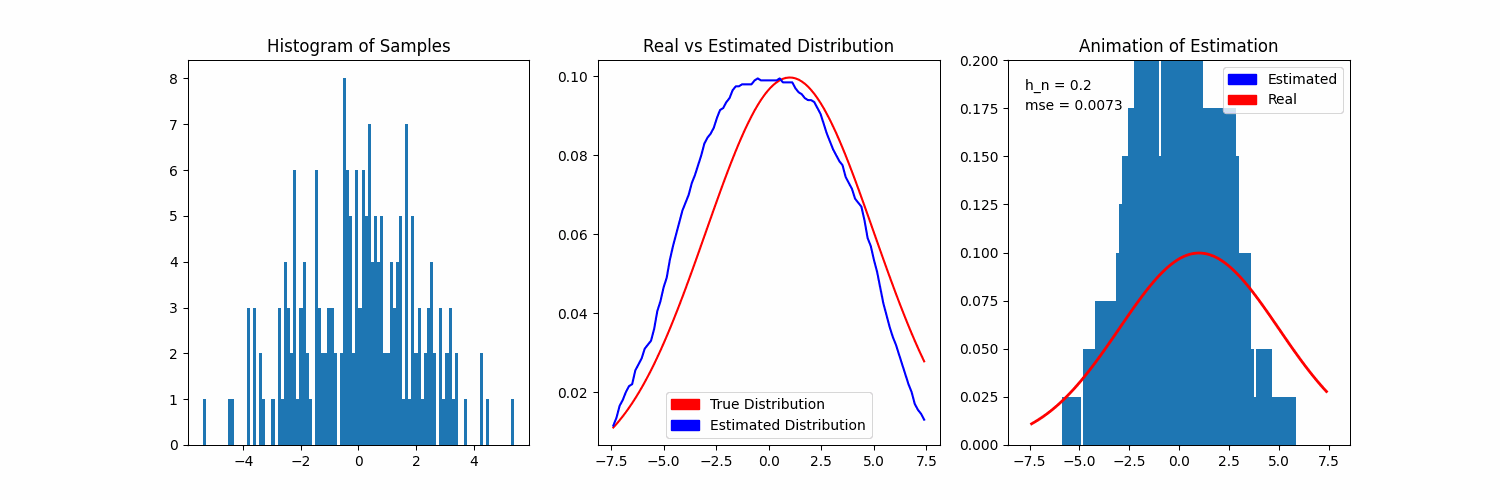



And using the Guassian Window shape we observe how a smaller window size, compared to the hypercube, is more suitable for this shape, as we estimate the PDF.

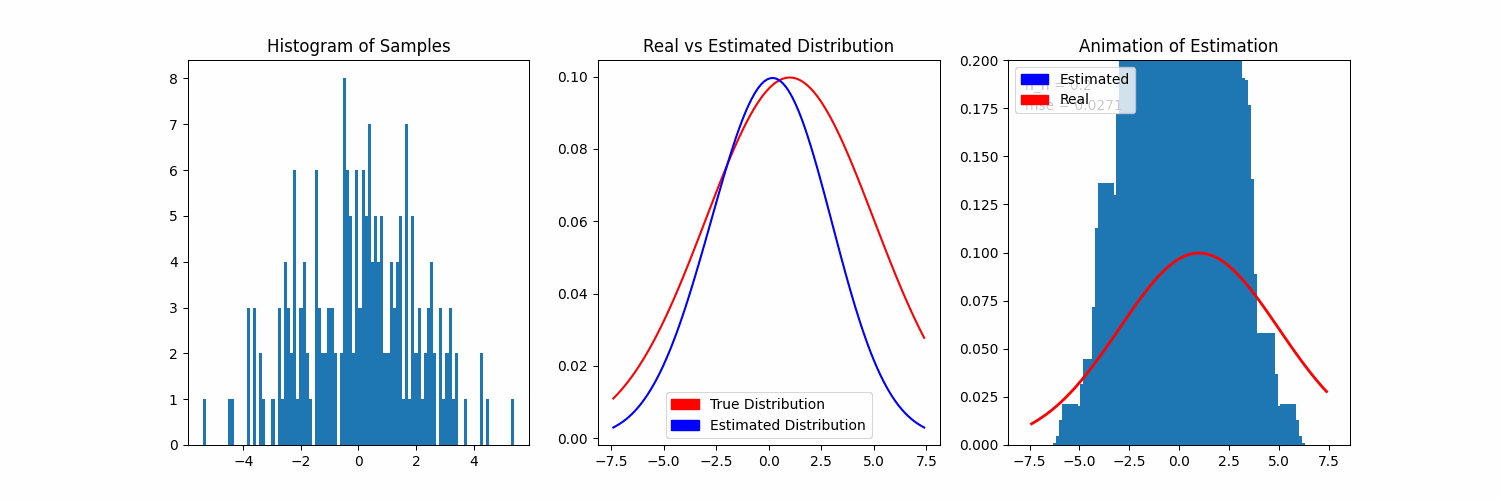

# **PART C: K-nearest Neighbors**

At this last part, we will take a look at the K-nearest Neighbors Classifier.

The algorithm, given a labeled training dataset, for each point of the grid, classifies which class the point belongs to, by assigning the most frequent class found on the #k nearest labeled data points.

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation
import matplotlib.patches as mpatches


def prepare_animation(ax, scatter_points, scatter_labels, xx, yy, posteriors, k_list, best_k):
    def animate(frame_number):
        if frame_number > 0 and k_list[frame_number - 1] == best_k:
            time.sleep(2)

        ax.clear()

        # plot anim, scatter
        plot = ax.contourf(xx, yy, posteriors[frame_number], alpha=.4)
        ax.scatter(scatter_points[:, 0], scatter_points[:, 1], c=scatter_labels, edgecolor='black')

        # add legend and title
        ax.set_title('Animation of KNN')

        colors = ['blue', 'yellow']
        labels = ['class_0', 'class_1']
        patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
        ax.legend(handles=patches)

        ax.text(0.05, 0.95, f'k = {k_list[frame_number]:.1f}', transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top')

        if k_list[frame_number] == best_k:
            ax.text(0.05, 0.9, 'Best k', transform=ax.transAxes,
                    fontsize=10,
                    verticalalignment='top')

        return plot

    return animate


# calculate euclidean distance between x and all points in train_data
# Input 1: x, a 1x2 array
# Input 2: train_data, a nx2 array
# Output: a nx1 array of distances
def calc_dist(x, train_data):
    # calculate the difference between x and each point in train_data
    diff = x - train_data

    # calculate the square of the difference
    sq_diff = np.square(diff)

    # calculate the sum of the square of the difference
    sum_sq_diff = np.sum(sq_diff, axis=1)

    # calculate the square root of the sum of the square of the difference
    dist = np.sqrt(sum_sq_diff)

    return dist


def import_data(filename):
    data = pd.read_csv(filename, header=None)

    # drop the third column
    labels = data.iloc[:, 2]
    data = data.drop(2, axis=1)
    return data.values, labels


# get the k nearest neighbors of x
# Input 1: x, a 1x2 array
# Input 2: train_data, a nx2 array
# Input 3: k, the number of neighbors
# Output: a kx1 array of indices of the k nearest neighbors
def get_knn(x, train_data, k):
    dist = calc_dist(x, train_data)
    # return the indices of the k smallest distances
    # excluding distance 0(smallest one), which is the distance between x and itself
    return np.argpartition(dist, k + 1)[1:k + 1]


# calculate probability of each sample belonging to each class
# Input 1: train_data, a nx2 array
# Input 2: train_labels, a nx1 array
# Input 3: test_data, a mx2 array
# Input 4: test_labels, a mx1 array
# Input 5: k, the number of neighbors
def calc_probs(train_data, train_labels, test_data, test_labels, k, debug=False):
    correct = 0
    predictions = []

    # calculate the probability of each sample belonging to each class
    for i in range(len(test_data)):
        # get the k nearest neighbors of the sample
        knn = get_knn(test_data[i], train_data, k)

        # get the labels of the k nearest neighbors
        knn_labels = train_labels[knn]

        # calculate the probability of the sample belonging to each class
        prob_0 = np.count_nonzero(knn_labels == 0) / k
        prob_1 = np.count_nonzero(knn_labels == 1) / k

        if debug:
            # print the probability of the sample belonging to each class
            print('Probability of sample', i + 1, 'belonging to class 0:', prob_0)
            print('Probability of sample', i + 1, 'belonging to class 1:', prob_1)

            # print the actual label of the sample
            print('Actual label of sample', i + 1, ':', test_labels[i])

        predictions.append(np.argmax([prob_0, prob_1]))

        if debug:
            # print the predicted label of the sample
            print('Predicted label of sample', i + 1, ':', predictions[i])
            print()

        if predictions[i] == test_labels[i]:
            correct += 1

    accuracy = correct / len(test_data)
    if debug:
        print(f"Accuracy: {accuracy:.2f}")

    return predictions, accuracy


# plot the data
def plot_data(train_data, train_labels, test_data, test_labels, preds):
    # create a 1x2 subplot
    fig, ax = plt.subplots(1, 2)

    # plot actual labels
    ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels)

    # plot predicted labels
    ax[1].scatter(test_data[:, 0], test_data[:, 1], c=preds)

    # set the title of the plot
    ax[0].set_title('Actual labels')
    ax[1].set_title('Predicted labels')

    plt.show()


def est_best_k(train_data, train_labels, test_data, test_labels, k_cands):
    results = []
    for k in k_cands:
        print('k =', k)
        preds, acc = calc_probs(train_data, train_labels, test_data, test_labels, k)
        results.append((k, preds, acc))

    return results


def getGrid(data, spacing=0.1):
    # create meshgrid based on data
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, spacing),
                         np.arange(y_min, y_max, spacing))

    return xx, yy


# calculate decision boundaries
def calc_decision_boundaries(samples, labels, xx, yy, k):
    Xgrid = np.c_[xx.ravel(), yy.ravel()]

    # calculate the probability of each point
    preds, acc = calc_probs(samples, labels, Xgrid, np.zeros(len(Xgrid)), k)

    # reshape the predictions
    Z = np.array(preds).reshape(xx.shape)

    return Z


def main():
    train_data, train_labels = import_data('dataC_ΚΝΝtrain.csv')
    test_data, test_labels = import_data('dataC_ΚΝΝtest.csv')

    k_cands = [1, 3, 5, 7, 9, 11, 13, 15]
    results = est_best_k(train_data, train_labels, test_data, test_labels, k_cands)

    best_k = max(results, key=lambda x: x[2])[0]
    print(f"Best k: {best_k}, accuracy: {max(results, key=lambda x: x[2])[2]:.2f}")

    spacing = 0.7
    xx, yy = getGrid(test_data, spacing)

    results = []
    for k in k_cands:
        curr_res = calc_decision_boundaries(train_data, train_labels, xx, yy, k)
        results.append(curr_res)
        print(f"Completed k={k}")

    fig, ax = plt.subplots()

    posts = np.arange(0, len(k_cands), 1)
    anim = animation.FuncAnimation(fig, prepare_animation(ax, test_data, test_labels, xx, yy, results, k_cands, best_k),
                                   len(posts), interval=800, repeat=True)


    plt.show()


if __name__ == '__main__':
    main()


After training the classifier on the training dataset, we can now input a test dataset and let the model decide which label to assign to each sample. <br>

We can go a bit further and for do this for a whole grid of points, which will allow us to see and animate the decision boundaries of our classifier in a more interactive way.

Although the animation does not render in jyputer notebook, I HIGHLY recommend running all 3 parts in a seperate IDE, we can save and display the result.

Below we see a scatter plot of the training dataset, and the decision boundaries for each k.

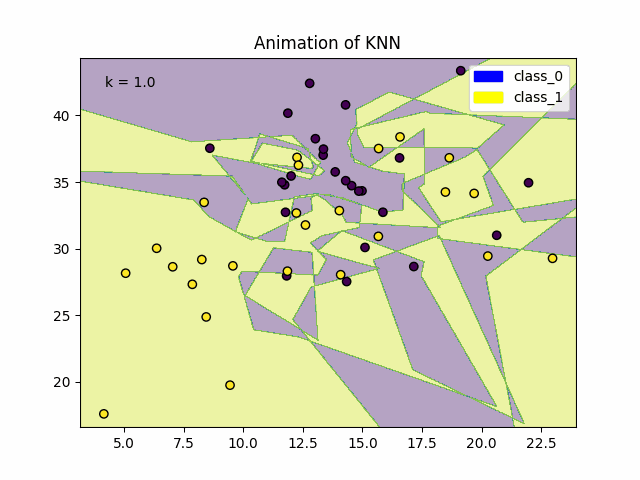

Now to get a better feel of how the test dataset is scored, we can scatter the test samples on the same decision boundaries.

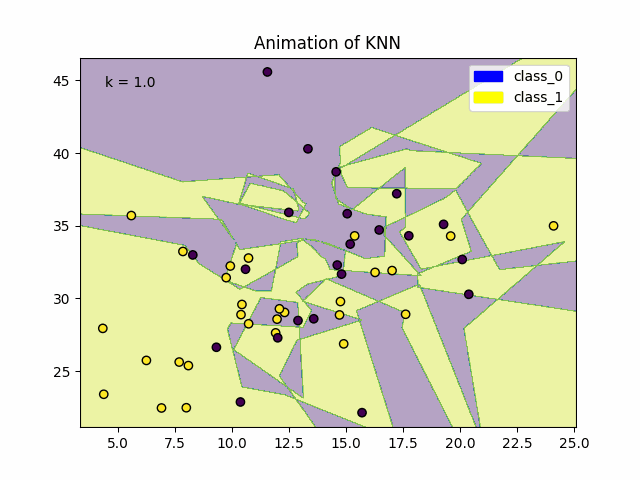

We notice how, for a small k value, the decision boundaries are too sensitive to the noise in the data. In contrast, as the k-value increases, we observe how it draws more broad decision boundaries.